### AJ Data Pre-Processing

In [66]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import csv
import json
import numpy as np
import tcxparser
import glob
import time
import statistics
import numpy
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#### Relevant Parameters of interest (user specific)

In [6]:
paths_to_data = {'fit':'../Data/Juan/Run/Fit', 'arduino':'../Data/Juan/Run'}
data_dir = '../Data/Juan/Run/'

path_to_tcx = 'Actividades/*_Correr.tcx'

file_names = sorted(glob.iglob(os.path.join(paths_to_data['fit'], path_to_tcx)))


In [7]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [8]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step (Avarage amplitude is calculated for each interval of n measurements)
                - Start is defined as the starting point of the first interval wich passes the avg threshold.
                - End is defined as the starting point of the first interval (from the end of the time series) wich passes the avg threshold.
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    
    df = data.copy().dropna()
    if method == 'inference':
        
        n = 100 # n=100 seemed like a good compromise to me in order to avoid detecting local changes.
        Y = [abs(x) for x in df.AccY.tolist()]
        ampl = [statistics.mean(Y[x:x+n]) for x in range(1,(len(Y)//n)*n,n)]
        start = np.where(np.array(ampl) > statistics.mean(ampl))[0][0]*n
        end = np.where(np.array(ampl[::-1]) > statistics.mean(ampl))[0][0]*n
        start_timestamp = df.iloc[[start]].index[0]
        end_timestamp = df.iloc[[len(Y)-end-1]].index[0]
        print('Number of observations excluded with inference method:', start+end)
        
        ########################## to be deleted, just for check
        plt.figure(figsize=(20,8))
        plt.plot(df.AccY.tolist(),color='#F7EBE8')
        plt.axvline(x=start, color='g', linestyle='--')
        plt.axvline(x=len(Y)-end, color='r', linestyle='--')
        plt.show()
        #######################################################
        
        df = df[df.index > start_timestamp]
        df = df[df.index < end_timestamp]
        
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [274]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None, google_files=file_names, period=1):
    
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several 
    time series into a single one). For this purpose we will simply do individual pre-processing steps on each 
    of the csv files and then merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)] 
    full_df = pd.DataFrame()
    
    google_df = load_tcx(google_files)
    
    for session in session_files:
                
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='inference',value=None)
        print(re.findall('\d+', session)[0])
        print('Session Start: ' + str(min(df_start.index)))
        print('Session End: ' + str(max(df_start.index)))
        reduce_tcx_df = google_df[(google_df.timestamp > str(min(df_start.index))) & 
                                  (google_df.timestamp < str(max(df_start.index)))].set_index('timestamp')
        
        #return reduce_tcx_df, df_start
        # Intermediate step to remove google data duplicates for distance and altitude seperately
        reduce_tcx_df.reset_index(level=0, inplace=True)
        dist_df = reduce_tcx_df.groupby('distance').last().reset_index(level=0).set_index('timestamp')
        alt_df = reduce_tcx_df.groupby('altitude').last().reset_index(level=0).set_index('timestamp')
        
        merged = df_start.merge(dist_df[['distance', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['distance'] = merged['distance'].interpolate(method='index')
        
        merged = merged.merge(alt_df[['altitude', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['altitude'] = merged['altitude'].interpolate(method='index')
        
        
        df_final = merged[~(merged.google_fit_x == True) | ~(merged.google_fit_y == True)]
        #df_final.dropna(subset=['altitude', 'distance'], inplace=True)
        df_final.drop(columns=['google_fit_x', 'google_fit_y'], inplace=True)
        df_final = df_final[(df_final.index > str(min(df_start.index))) & 
                             (df_final.index < str(max(df_start.index)))]
        
        # Add pace to as feature
        df_final['delta_distance']= df_final.distance.diff(periods=period)
        df_final['delta_time'] = [0]*period+[(df_final.index[i]-df_final.index[i-period]).total_seconds() 
                                                for i in range(period,df_final.shape[0])]
        df_final = df_final[period:]
        df_final['pace']=(df_final.delta_distance/1000)/(df_final.delta_time/3600)
        
        print('+++++++++++++++')
        full_df = pd.concat([full_df, df_final])        
        
        
    print('Finished pre-processing individual time series')
    full_df.sort_values(by='timestamp', inplace=True)
    
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
     
    
    return full_df
    

In [10]:
def load_tcx(file_list):
   
    """
    Load tcx files into pandas DataFrame
    
    Known issue: 
    the lists altitude, timestamp and distance have not the same length;
    we don't know the position of the missing data (potential values' shift);
    """
    df = pd.DataFrame(columns=['timestamp','altitude',
                               'distance', 
                               'google_fit'])
    
    for file in file_list:
        tcx_obj = tcxparser.TCXParser(file)
        default_len = min([len(tcx_obj.time_values())],
                          [len(tcx_obj.altitude_points())],
                          [len(tcx_obj.distance_values())])[0]
        data_dict = {'timestamp':tcx_obj.time_values()[-default_len:], 
                     'altitude':tcx_obj.altitude_points()[-default_len:], 
                     'distance':tcx_obj.distance_values()[-default_len:],
                     'google_fit': [True] * default_len}
        tmp_df = pd.DataFrame.from_dict(data_dict)
        df = pd.concat([df, tmp_df], ignore_index=True)
        print('======================')
        
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
    hours_added = timedelta(hours = 2)
    df['timestamp'] = df['timestamp'] + hours_added
    df['distance'] = pd.to_numeric(df.distance.astype(str))
        
    return df.sort_values(by='timestamp')

Number of observations excluded with inference method: 3600


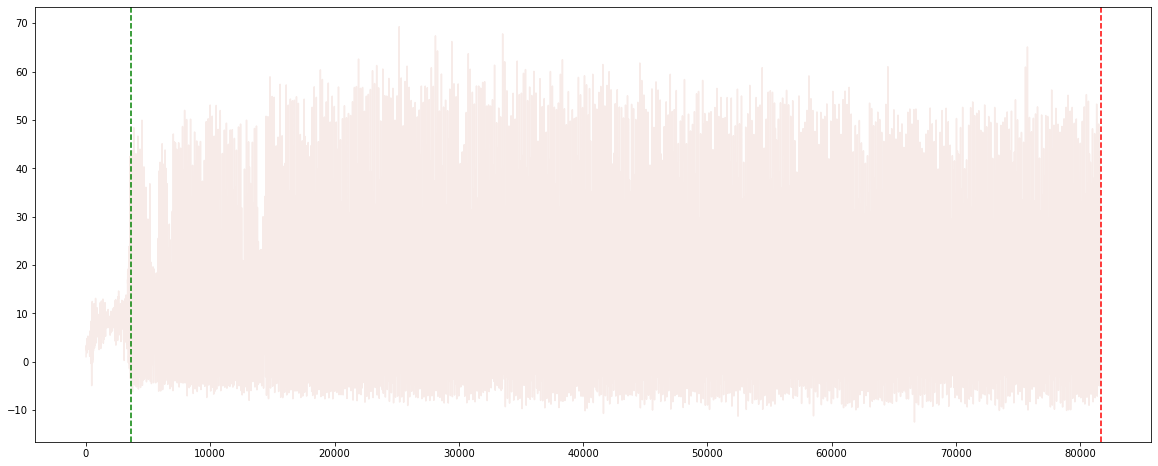

0205
Session Start: 2021-05-02 18:00:25.444000
Session End: 2021-05-02 18:06:20.425000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 3200


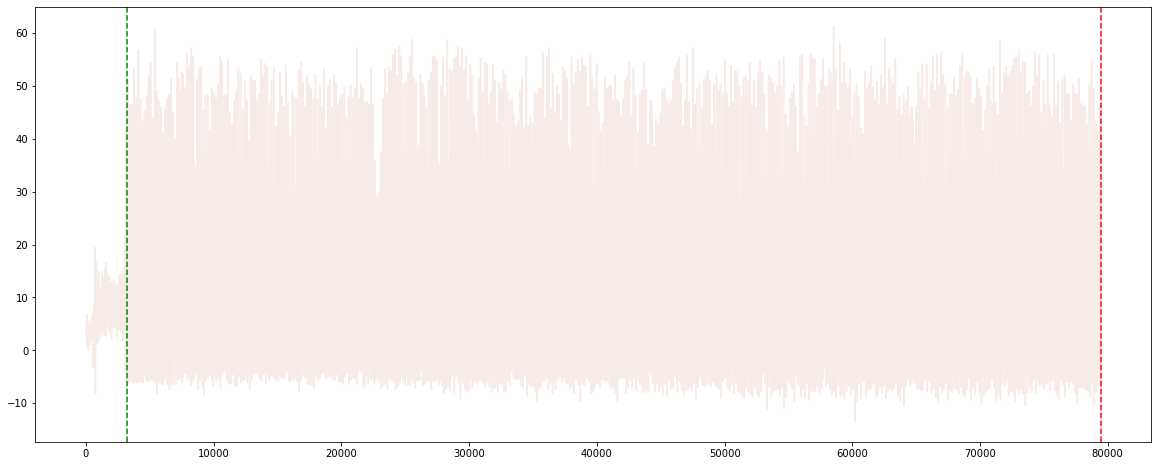

0405
Session Start: 2021-05-04 18:58:46.296000
Session End: 2021-05-04 19:04:34.157000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 3300


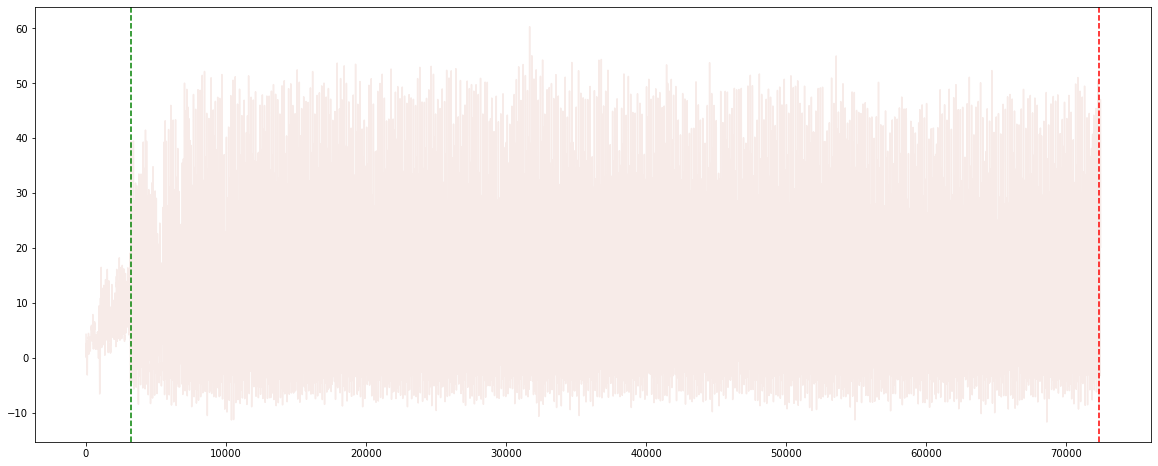

0705
Session Start: 2021-05-07 18:34:08.828000
Session End: 2021-05-07 18:39:29.741000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 12100


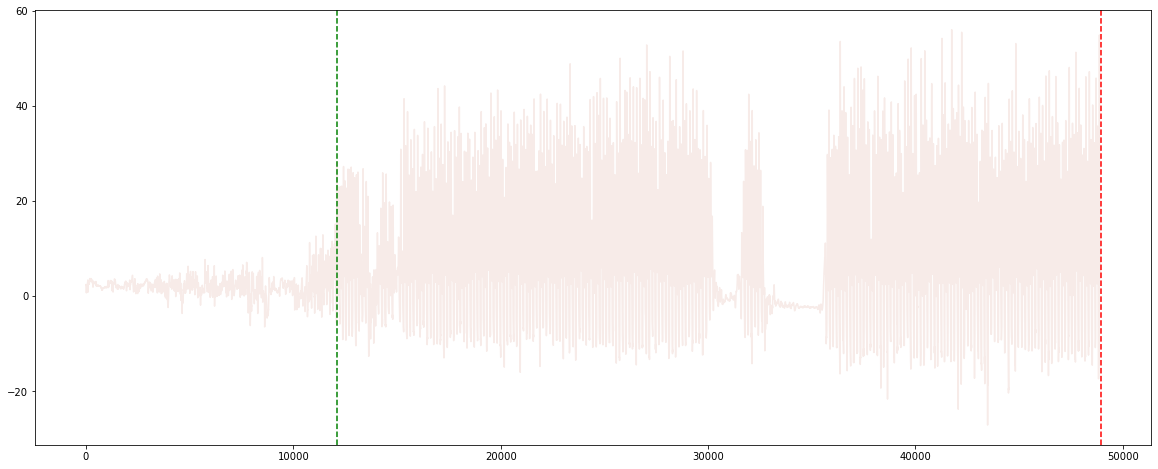

1304
Session Start: 2021-04-13 18:51:32.530000
Session End: 2021-04-13 18:54:21.900000
+++++++++++++++
Number of observations excluded with inference method: 9600


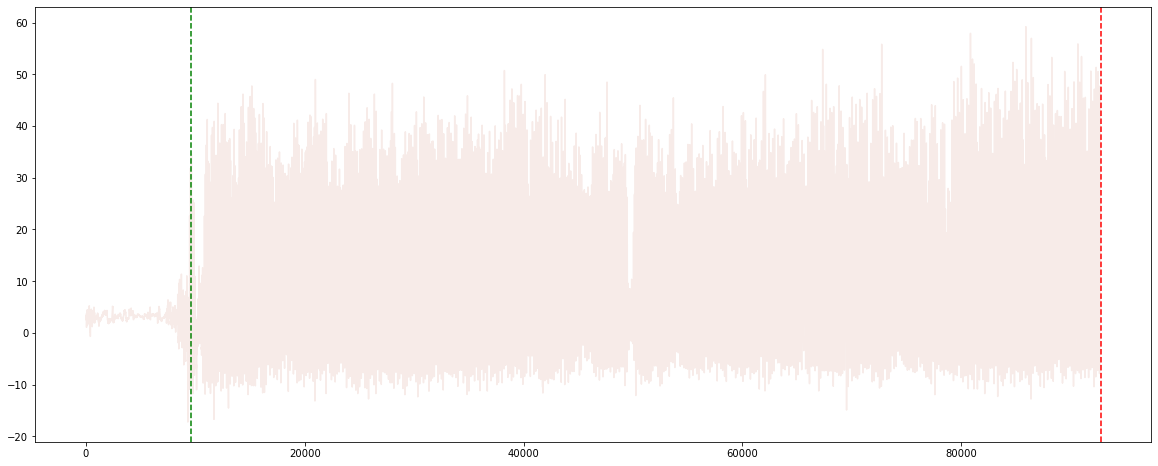

1504
Session Start: 2021-04-15 17:25:58.756000
Session End: 2021-04-15 17:32:12.595000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 10000


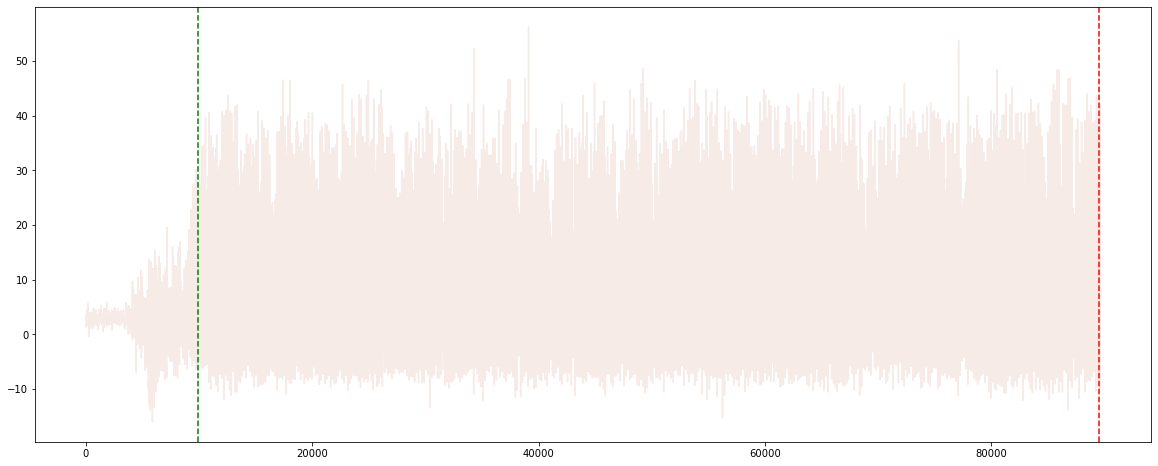

1604
Session Start: 2021-04-16 19:17:51.217000
Session End: 2021-04-16 19:23:54.212000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 2600


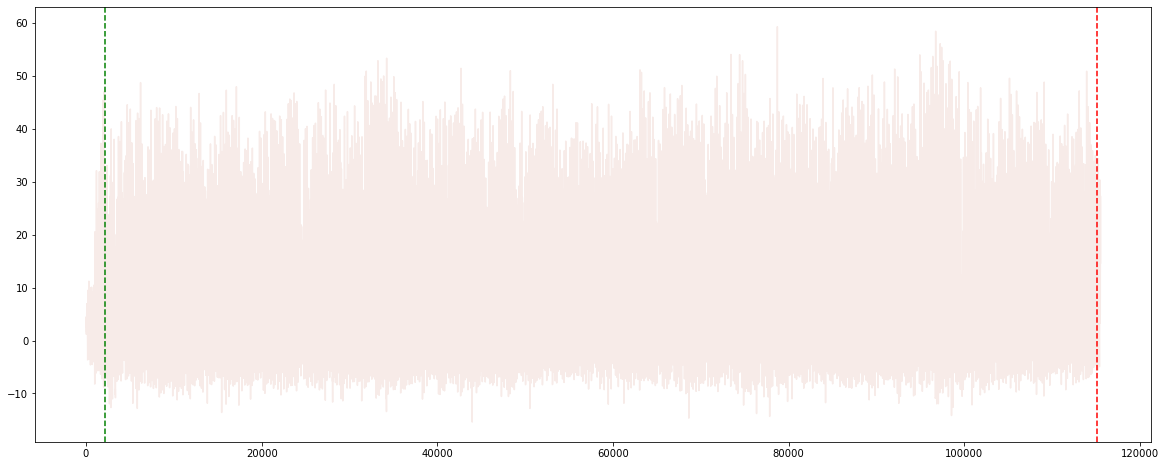

2104
Session Start: 2021-04-21 19:00:43.149000
Session End: 2021-04-21 19:09:07.946000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 2500


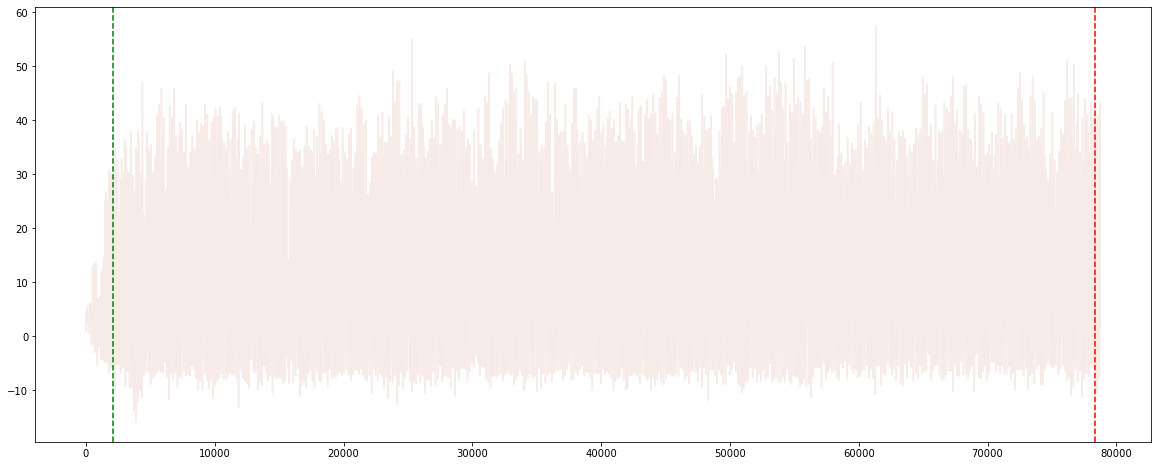

2204
Session Start: 2021-04-22 19:14:35.703000
Session End: 2021-04-22 19:20:16.057000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 2000


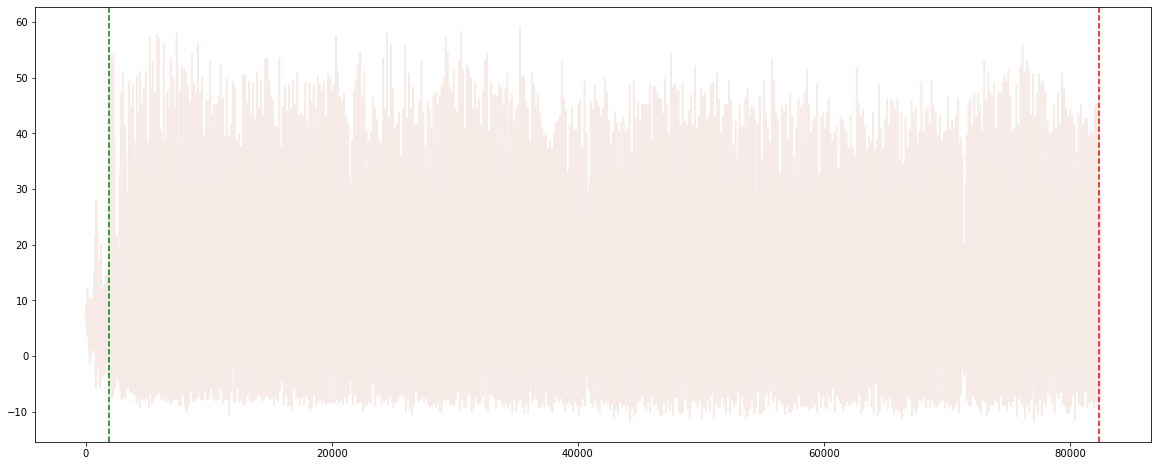

2404
Session Start: 2021-04-24 19:17:59.281000
Session End: 2021-04-24 19:24:34.615000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 1000


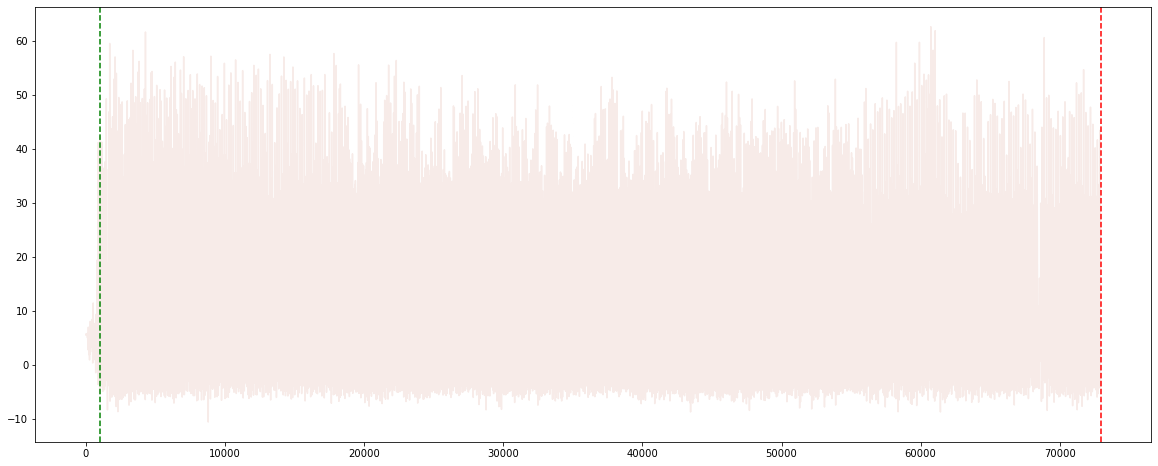

2704
Session Start: 2021-04-27 18:49:01.882000
Session End: 2021-04-27 18:58:58.329000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Number of observations excluded with inference method: 4400


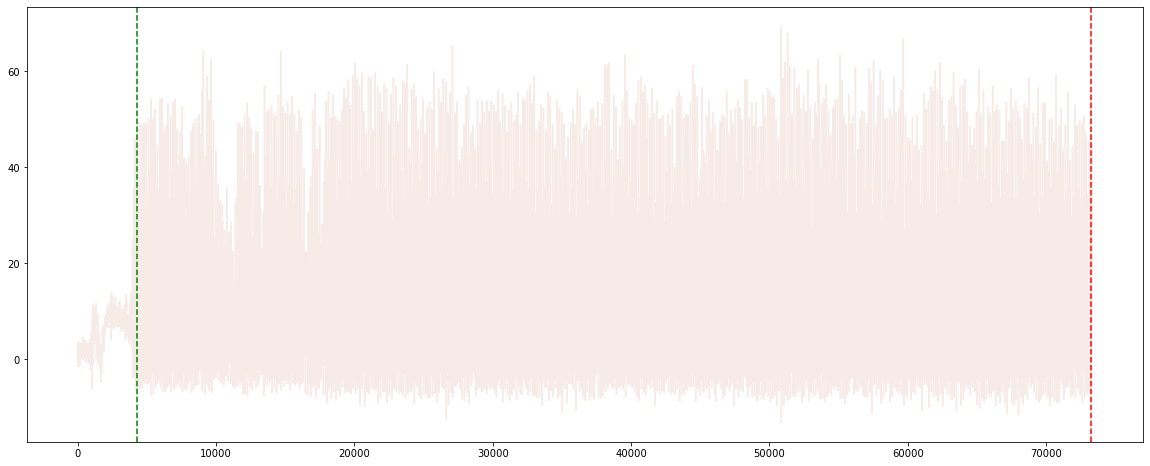

3004
Session Start: 2021-04-30 19:01:58.098000
Session End: 2021-04-30 19:07:10.619000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Finished pre-processing individual time series


In [12]:
#tcx_df = load_tcx(file_names)
full = generate_full_time_series_AJ('../Data/Juan/Run/')

Number of observations excluded with inference method: 2000


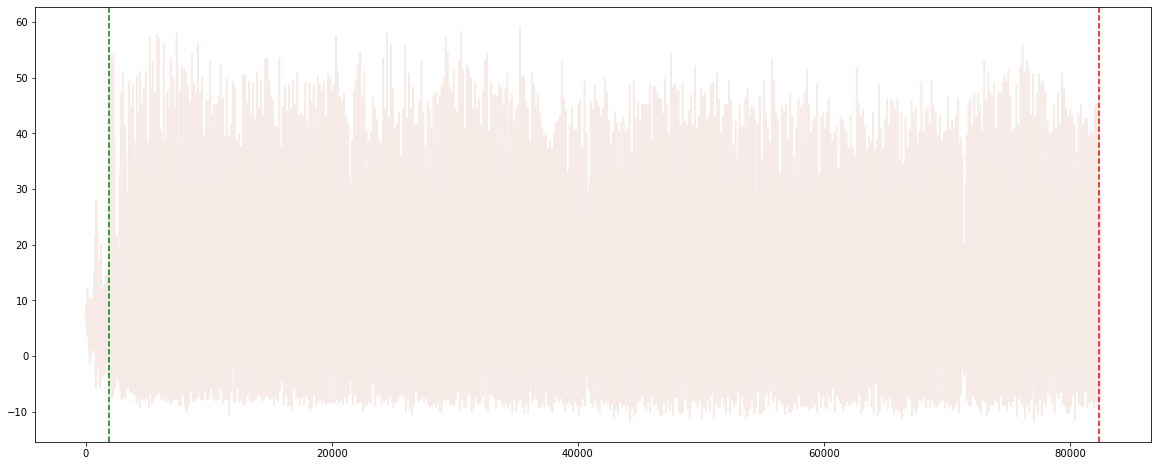

2404
Session Start: 2021-04-24 19:17:59.281000
Session End: 2021-04-24 19:24:34.615000


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


+++++++++++++++
Finished pre-processing individual time series


In [275]:
run9 = generate_full_time_series_AJ('../Data/Juan/Run/', file_identifier='Run_2404')

In [278]:
run9.shape

(80658, 14)

In [282]:
def identify_peaks(data, feature='AccY', height=0, distance=20, plot_check=[10000, 15000]):
    """
    For this function we provide a dataset and we return the same dataset with two additional features:
     - step: Indicator of when a set has been made. Since this estimation is based on the Acc it will in reality be 2 steps
     - peak_height: Moment in which the peak was identified, what was the height of the peak
    :param data: Dataframe where we will include the features
    :param feature: What is the feature variable over which this estimation will be done (this will depend on the run session)
    :param height: Reference value for peak_height
    :param distance: Minimum distance in index terms between two peaks. This is a tunning parameter which depends on the 
        session
    :param plot_check: If provided, as output we will also get a plot to see whether the step checker has worked properly
    **Disclaimer: This is not an exact appproach, rather an approximation. Therefore this should be done ideally for each
        individual session independently
    """
    
    df = data.copy()
    x = np.array(df[feature])
    peaks, properties = find_peaks(x, height=height, distance=distance)
    if plot_check:
        plt.figure(figsize=(15, 8))
        plt.plot(x)
        plt.plot(peaks, x[peaks], "x")
        plt.plot(np.zeros_like(x), "--", color="gray")
        plt.xlim(plot_check[0], plot_check[1])
        plt.show()
    
    step = [0]*len(df)
    peak_height = [0]*len(df)
    j = 0
    for i in peaks:
        step[i] = 2
        peak_height[i] = properties['peak_heights'][j]
        j+=1

    df['step'] = step
    df['peak_height'] = peak_height
    
    return df

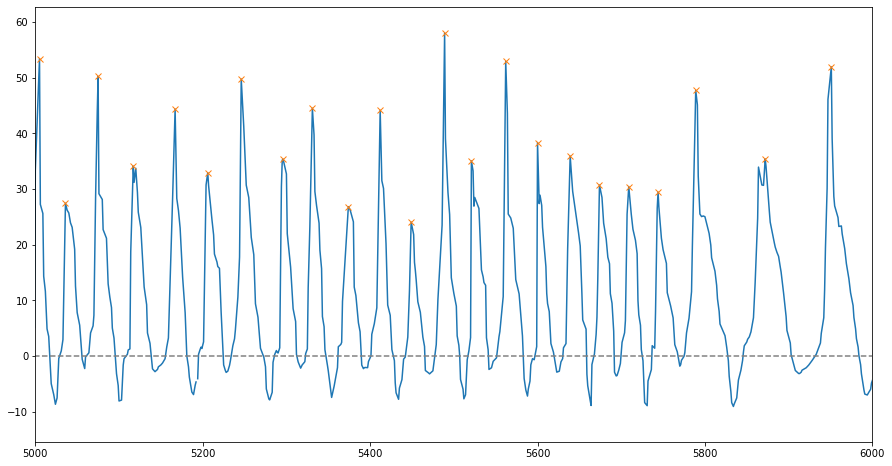

In [283]:
run9_peaks = identify_peaks(run9, plot_check=[5000,6000], distance=20)

In [281]:
run9_peaks[100:150]

,AmbientLightSensor,DecibelSource,PitchSensor,LinearAccelerometerSensor,AccX,AccY,AccZ,CompassSensor,MagneticRotationSensor,distance,altitude,delta_distance,delta_time,pace,step,peak_height
timestamp,,,,,,,,,,,,,,,,
2021-04-24 19:18:00.221,9661.000000,31.098139,84.680250,7.497605,-3.636230,8.197601,1.738594,178.094498,46.635251,31.709879,69.838757,0.057770,0.018,11.554083,0,0.000000
2021-04-24 19:18:00.232,12392.000000,26.194095,84.680250,7.455352,-3.407318,7.482147,1.426331,178.929373,46.369850,31.745184,69.853249,0.035305,0.011,11.554232,0,0.000000
2021-04-24 19:18:00.233,12392.000000,21.290051,84.680250,7.413099,-3.054774,5.616542,0.664617,186.481366,46.369850,31.748393,69.854566,0.003209,0.001,11.553425,0,0.000000
2021-04-24 19:18:00.261,12392.000000,16.386007,84.680250,7.370845,-2.702230,3.750936,-0.097097,188.767813,47.257488,31.838259,69.891454,0.089866,0.028,11.554165,0,0.000000
2021-04-24 19:18:00.267,12392.000000,15.381682,75.271333,7.328592,-2.349686,1.885330,-0.858810,191.054260,48.145126,31.857516,69.899359,0.019257,0.006,11.554411,0,0.000000
2021-04-24 19:18:00.269,12392.000000,14.377357,65.862417,8.679076,-0.732132,-3.862228,-2.337585,209.970838,48.390470,31.863935,69.901994,0.006419,0.002,11.553425,0,0.000000
2021-04-24 19:18:00.301,12392.000000,13.373032,56.453500,10.029559,-0.486870,-4.542992,-2.369888,211.605644,48.635814,31.966638,69.944152,0.102704,0.032,11.554165,0,0.000000
2021-04-24 19:18:00.302,12392.000000,13.480784,47.044583,11.380042,-0.241608,-5.223755,-2.402191,213.240449,48.881157,31.969848,69.945470,0.003210,0.001,11.556383,0,0.000000
2021-04-24 19:18:00.307,14210.166667,13.588535,37.635667,12.730526,-0.354065,-5.702316,-2.306473,218.463372,47.806661,31.985896,69.952057,0.016047,0.005,11.554017,0,0.000000


In [295]:
ind_df = run9_peaks.groupby(pd.Grouper(freq='5S')).agg({'AccX':['min', 'max', 'mean', 'median', 'std'], 
                                               'AccY':['min', 'max', 'mean', 'median', 'std'],
                                               'AccZ':['min', 'max', 'mean', 'median', 'std'],
                                               'DecibelSource':['min', 'max', 'mean', 'median', 'std'],
                                               'PitchSensor':['min', 'max', 'mean', 'median', 'std'],
                                               'step':['sum'],
                                               'peak_height':['max', 'min'],
                                               'pace':['min', 'max', 'mean', 'median', 'std']})
ind_df.columns = ['_'.join(col).strip() for col in ind_df.columns.values]
ind_df